# SPARKIFY DATA MODELING
### Introduction
Sparkify wants to analyze the data we've been collecting on songs and user activity on our new music streaming app. The analysis team is particularly interested in understanding what songs users are listening to. 

### Current Issue
Currently, there is no easy way to query the data to generate the results, since the data reside in a directory of CSV files on user activity on the app.

### Proposed Solution
We ought to create an Apache Cassandra database which can create queries on song play data to answer relevant business questions. To achieve this, we need to:

**1. ETL Pipeline:** <br>
Complete an ETL pipeline using Python that transfers data from a set of CSV files within a directory to create a streamlined CSV file to model and insert data into Apache Cassandra tables.

**2. Model Data** <br>
Data should be modeled as to answer the following questions:
* What are the artist, song title and song's length in any given sessionId and itemInSession? For instance, sessionId = 338 and itemInSession  = 4.
> table name: `song_library` <br> query: `select artist,song,length from from WHERE sessionId=338 AND itemInSession=4;`

* What artist and song (sorted by itemInSession) any given user (userId, first and last names) has listened to at any given session (sessionId)? For instance, userid = 10 and sessionid = 182
> table name: `user_artist_library` <br> query: `select artist,song,firstName,lastName) from sparkify WHERE sessionId=182 AND userId=10;`

* Which users (first and last names) have listened to any given song? For example, the song 'All Hands Against His Own'.
> table name: `song_user_library` <br> query: `select firstName lastName from sparkify WHERE song='All Hands Against His Own';`

### Step 0. Importing necessary packages

In [119]:
# Import Python packages 
import pandas as pd
import cassandra
import re
import os
import glob2 as glob
import numpy as np
import json
import csv
import traceback

## Step 1. ETL Pipeline for Pre-Processing the Files

#### Creating list of filepaths to process original event csv data files

In [120]:
# checking current working directory
print(os.getcwd())

# Get current folder and subfolder event data
filepath = os.getcwd() + '/event_data'

# Create a for loop to create a list of files and collect each filepath
for root, dirs, files in os.walk(filepath):
    
# join the file path and roots with the subdirectories using glob
    file_path_list = glob.glob(os.path.join(root,'*'))
    #print(file_path_list)

/Users/lucasaledi/Documents/udacity_data_engineering/data_modeling/project_sparkify


#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [121]:
# initiating an empty list to which append each row of each file
full_data_rows_list = [] 
    
# for every filepath in the file path list 
for f in file_path_list:
    # reading csv file 
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
        # skips header
        next(csvreader)
        # extracting each data row one by one and append it        
        for line in csvreader:
            #print(line)
            full_data_rows_list.append(line) 
            
# creating a smaller event data csv file called event_datafile_full 
## that will be used to insert data into Apache Cassandra tables
csv.register_dialect('myDialect'
                     ,quoting=csv.QUOTE_ALL
                     ,skipinitialspace=True)

with open('event_datafile_new.csv'
          ,'w'
          ,encoding='utf8'
          ,newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender'
                     ,'itemInSession','lastName','length'
                     ,'level','location','sessionId'
                     ,'song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0],row[2],row[3],row[4]
                         ,row[5],row[6],row[7]
                         ,row[8],row[12],row[13],row[16]))

# check the number of rows in your csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))

6821


## Step 2. Data Modeling - Apache Cassandra Tables
The `event_datafile_new.csv` contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

Below is an image of how the denormalized data should look like in the `event_datafile_new.csv` coming out of the ETL pipeline.
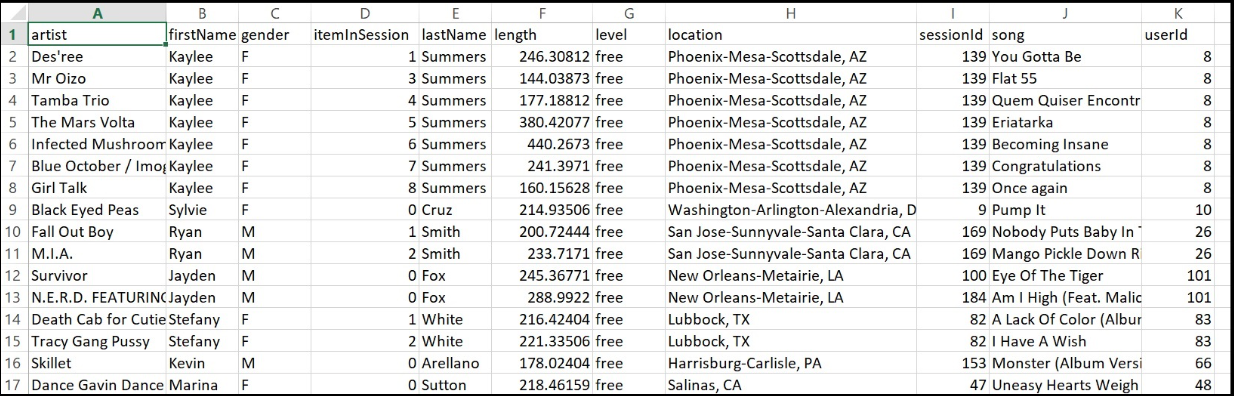

#### Creating Cluster and initializing session

In [122]:
# Connection to a Cassandra instance in local machine 
# (127.0.0.1)
from cassandra.cluster import Cluster
try:
    cluster = Cluster(['127.0.0.1'])
    # Create session
    session = cluster.connect()
except Exception as e:
    traceback.print_exception(e,limit=None)

In [123]:
# Create Sparkify Keyspace 
try:
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS sparkify 
        WITH REPLICATION = 
            { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }
    """)

except Exception as e:
    traceback.print_exception(e,limit=None)

# Set KEYSPACE to the keyspace specified above
try:
    session.set_keyspace('sparkify')
except Exception as e:
    traceback.print_exception(e,limit=None)

### Creating tables
### 1. What are the artist, song title and song's length in any given sessionId and itemInSession? For instance, sessionId = 338 and itemInSession  = 4.
> table name: `song_library` <br> query: `select artist,song,length from from WHERE sessionId=338 AND itemInSession=4;`

In [124]:
## Query 1
query = """
CREATE TABLE IF NOT EXISTS song_library (
    sessionId int
    ,itemInSession int
    ,artist text
    ,song text
    ,length float
    ,PRIMARY KEY (sessionId, itemInSession)
);
"""
try:
    session.execute(query)
except Exception as e:
    traceback.print_exception(e,limit=None)

In [125]:
try:
    # File containing data
    file = 'event_datafile_new.csv'
    with open(file, encoding = 'utf8') as f:
        csvreader = csv.reader(f)
        next(csvreader) # skip header
        for line in csvreader:
        ## Assign the INSERT statements into the `query` variable
            query = "INSERT INTO song_library (sessionId,itemInSession,artist,song,length)"
            query = query + " VALUES (%s, %s, %s, %s, %s)"
            ## Assign which column element should be assigned for each column in the INSERT statement.
            ## For e.g., to INSERT artist_name and user first_name, you would change the code below to `line[0], line[1]`
            ## csvreader returns each row as a list of strings (https://stackoverflow.com/a/55779027/13043172)
            ## for non-string type, dtype was passed explicitly
            #print(line[8], line[3], line[0], line[9], line[5])
            session.execute(query, (int(line[8]), int(line[3]), line[0], line[9], float(line[5])))
except Exception as e:
    traceback.print_exception(e,limit=None)        

In [126]:
## SELECT statement to verify the data was entered into the table
query = """
SELECT 
    artist
    ,song
    ,length
FROM song_library 
WHERE sessionId = 338 
AND itemInSession = 4;
"""
try:
    rows = session.execute(query)
    song_library = pd.DataFrame(list(rows))
except Exception as e:
    traceback.print_exception(e,limit=None)
song_library

,artist,song,length
0,Faithless,Music Matters (Mark Knight Dub),495.307312


### 2. What artist and song (sorted by itemInSession) any given user (userId, first and last names) has listened to at any given session (sessionId)? For instance, userid = 10 and sessionid = 182
> table name: `user_artist_library` <br> query: `select artist,song,firstName,lastName from sparkify WHERE sessionId=182 AND userId=10;`

In [127]:
## Query 2
query = """
CREATE TABLE IF NOT EXISTS user_artist_library (
    sessionId int
    ,userId int
    ,itemInSession int
    ,artist text
    ,song text
    ,firstName text
    ,lastName text
    ,PRIMARY KEY ((sessionId,userId), itemInSession)
);
"""
try:
    session.execute(query)
except Exception as e:
    traceback.print_exception(e,limit=None)

In [128]:
try:
    # File containing data
    file = 'event_datafile_new.csv'
    with open(file, encoding = 'utf8') as f:
        csvreader = csv.reader(f)
        next(csvreader) # skip header
        for line in csvreader:
        ## Assign the INSERT statements into the `query` variable
            query = "INSERT INTO user_artist_library (sessionId,userId,itemInSession,artist,song,firstName,lastName)"
            query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s)"
            ## Assign which column element should be assigned for each column in the INSERT statement.
            ## For e.g., to INSERT artist_name and user first_name, you would change the code below to `line[0], line[1]`
            ## csvreader returns each row as a list of strings (https://stackoverflow.com/a/55779027/13043172)
            ## for non-string type, dtype was passed explicitly
            #print(line[8], line[3], line[0], line[9], line[5])
            session.execute(query, (int(line[8]), int(line[10]), int(line[3]), line[0], line[9], line[1], line[4]))
except Exception as e:
    traceback.print_exception(e,limit=None)

#### Issue with combining user's first and last names and UDF solution
Apache Cassandra does not have an built-in CONCAT function as in most relational databases. However, it offers User-defined functions (or UDFs) as an alternative for running scripts defined by the user in the server-side. A pre-requisite for implementing this solution is to modify .yaml file. `cassandra.yaml` contains `user_defined_functions_enabled` attribute which needs to be set as `true`. This has been done in local machine ([source](https://cassandra.apache.org/doc/latest/cassandra/configuration/cass_yaml_file.html#user_defined_functions_enabled)).

* documentation: <br>https://cassandra.apache.org/doc/latest/cassandra/cql/functions.html#user-defined-scalar-functions
* using python-driver:
<br>https://www.datastax.com/blog/cassandra-user-defined-functions-using-python-driver
* example: 
<br>https://www.geeksforgeeks.org/user-defined-function-in-cassandra/

In [129]:
## Block below creates CONCAT function in Java and passes to CQL
query = """
CREATE OR REPLACE FUNCTION concat(fn text, ln text)
RETURNS NULL ON NULL INPUT
RETURNS text
LANGUAGE java
AS '
    String firstName = fn;
    String lastName = ln;
    return firstName+" "+lastName;
';
"""
try:
    session.execute(query)
except Exception as e:
    traceback.print_exception(e,limit=None)

In [130]:
## SELECT statement to verify the data was entered into the table
# Cassandra is lower-casing columns names
query = """
SELECT 
    artist
    ,song
    ,concat(firstname,lastname) AS user
FROM user_artist_library
WHERE userid = 10
AND sessionid = 182;
"""
try:
    rows = session.execute(query)
    user_artist_library = pd.DataFrame(list(rows))
except Exception as e:
    traceback.print_exception(e,limit=None)
user_artist_library

,artist,song,user
0,Down To The Bone,Keep On Keepin' On,Sylvie Cruz
1,Three Drives,Greece 2000,Sylvie Cruz
2,Sebastien Tellier,Kilometer,Sylvie Cruz
3,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,Sylvie Cruz


### 3. Which users (first and last names) have listened to any given song? For example, the song 'All Hands Against His Own'.
> table name: `song_user_library` <br> query: `select firstName lastName from sparkify WHERE song='All Hands Against His Own';`

#### ALLOW FILTERING AND INDICES
After getting ALLOW FILTERING error a few times, I decided to use column `song` as primary key and `userId` as clustering column (as to get all users).
More on how to avoid this error on [this link](https://www.datastax.com/blog/allow-filtering-explained).

In [131]:
## Query 3
query = """
CREATE TABLE IF NOT EXISTS song_user_library (
    song text
    ,userId int
    ,firstName text
    ,lastName text
    ,PRIMARY KEY (song, userId)
);
"""
try:
    session.execute(query)
except Exception as e:
    traceback.print_exception(e,limit=None)

In [132]:
try:
    # File containing data
    file = 'event_datafile_new.csv'
    with open(file, encoding = 'utf8') as f:
        csvreader = csv.reader(f)
        next(csvreader) # skip header
        for line in csvreader:
        ## Assign the INSERT statements into the `query` variable
            query = "INSERT INTO song_user_library (song,userId,firstName,lastName)"
            query = query + " VALUES (%s, %s, %s, %s)"
            ## Assign which column element should be assigned for each column in the INSERT statement.
            ## For e.g., to INSERT artist_name and user first_name, you would change the code below to `line[0], line[1]`
            session.execute(query, (line[9],int(line[10]),line[1],line[4]))
except Exception as e:
    traceback.print_exception(e,limit=None)

In [133]:
## Add in the SELECT statement to verify the data was entered into the table
# Cassandra is lower-casing columns names
query = """
SELECT
    concat(firstname,lastname) AS user
FROM song_user_library
WHERE song = 'All Hands Against His Own';
"""
try:
    rows = session.execute(query)
    song_user_library = pd.DataFrame(list(rows))
except Exception as e:
    traceback.print_exception(e,limit=None)
song_user_library

,user
0,Jacqueline Lynch
1,Tegan Levine
2,Sara Johnson


#### Drop functions and the tables and close out the session

In [134]:
## Drop concat UDF before closing out the sessions
query = "drop function concat"
try:
    rows = session.execute(query)
except Exception as e:
    traceback.print_exception(e,limit=None)

## Drop the table before closing out the sessions
query = "drop table song_library"
try:
    rows = session.execute(query)
except Exception as e:
    traceback.print_exception(e,limit=None)
    
query = "drop table user_artist_library"
try:
    rows = session.execute(query)
except Exception as e:
    traceback.print_exception(e,limit=None)

query = "drop table song_user_library"
try:
    rows = session.execute(query)
except Exception as e:
    traceback.print_exception(e,limit=None)
    
## Close session
session.shutdown()
cluster.shutdown()